## Rover Project Test Notebook
This notebook contains the functions the will be used to drive the rover in the RoboND simulator.

The requirements are the following 

* The code to be written needs to interact with the simulator through a socket in order to read telemetry and image data. It will also feed the simulator regularly with control data in the form of throttle, steering and braking.
* Given the image data, we need to determine the navigable terrain and draw it on a world map that will be fed back to the simulator and drawn on the right bottom corner of the screen
* Given the image data, deduce the non-navigable terrain and draw it on a world map that will be fed back to the simulator and drawn on the right bottom corner of the screen
* The rover shall avoid obstacles in a proper way.
* The rover shall map at least cover 40% of the world.
* The rover shall determine the navigable terrain with at least 60% fidelity compared to the true world map.
* The rover shall at least detect one small yellow rock.
* (Optionla) The rover shall collect the samples, these are the small yellow rocks.

In this nodebook we inspect first the image data given by the robot. For this, we run the simulator in manual mode and record images to be used for testing.

The main goal of this notebook is to write the proper logic for the function `process_image`. later on, when we are satisfied with the results, we will copy pase this function into the control code of the simulator.



In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()


## Quick Look at the Data
As a firs step, it is important to know how the data looks like. For this, a series of images are recorded from a manual run of the simulator and saved in `test_dataset` folder.  


From this folder, we read in and display a random image and see how it does look like

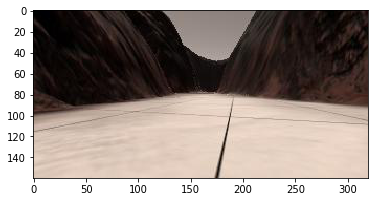

In [3]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data

In the following step, we have copied two images of interest into the `calibration_images` folder. The left image will be used to develop the perspective transform and the color thresholding. The right side image is an example of a rock and will be used to write the detection algorithm. 


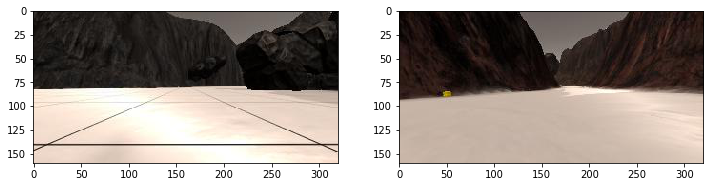

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock3.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

#grid_img = np.array(grid_img0, copy=True)

#grid_img[0:90,:,:] = 0


fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

In our case, given the image data, we will employ a perspective transform as a first step. This transform is basically a method to estimate a top-view of a given perspective camera image.

In order for this transform to work, the calibration image is used to determine the source and destinaton parameters (parameters for the transformation). 

In real world scenario, we place four points representing a given box on the ground and align the camera in a way that the two bottom points of the box are parallel to the camera horizontal line (same pixel coordinate in the vertical direction).

In our case, we simulated this box with an image with the grid enable (1x1meter). As illustrated in the left image above.

the function `calibration_images` below use OpenCV library to call `warpPerspective` which fulfill our need. To account for the FOV of the camera, we are also returning a mask image

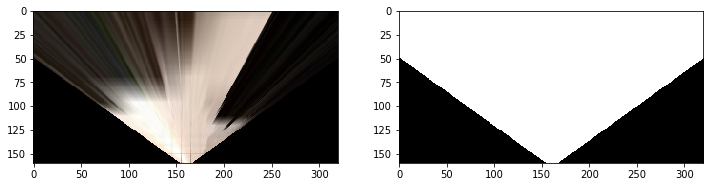

In [5]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    mask0   = cv2.warpPerspective(np.ones_like(img[:,:,0]), M, (img.shape[1], img.shape[0]))
    mask =  np.array(mask0, copy=True)
    # there is other ways to do this : mask for field of view of camera
    return warped, mask


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 0
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped, mask = perspect_transform(grid_img, source, destination)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(mask, cmap='gray')

#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding

The following function is used to reduce the amount of information from the image, we threshold the colors and reduce the image to black and white. White representing the navigable terrain and Black for anything else


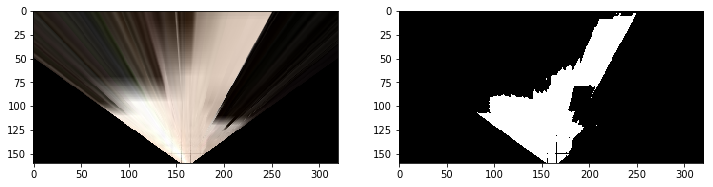

In [6]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(180, 180, 180)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations

The functions below are helpers to perform multiple usefull transformations.

* `rover_coord` takes a binary image (post color thresholding) and convert each pixel coordinate into a metric coordinate in relation to the rover. 
* `to_polar_coords` is used to convert from X,Y coordinate into a Distance and angle from the rover frame of reference origin.

* `rotate_pix` and `translate_pix` are standard 2-D transformations to express the coordinate of a given point in reference to one frame or the other. In this case, they will be used transform the pixels X,Y positions from the rover frame to the world frame.

* `pix_to_wold` is the full transformation from the rover coord to the world coords.

Note the scaling factor that is included in the translation operation. This scaling is used to re-scale to the world map view. In the given world view, a 10x10 meter box is represented by 1x1 px box but in the rover frame, 1x1m represents 10x10px

In bottom right resulting image, we draw a box in front of the rover. this box represents the safe navigation zone of the rover and will be used to determine when to stop or start driving. The logic is a simple ratio calculation of the number of navigable pixels vs obstacle pixels

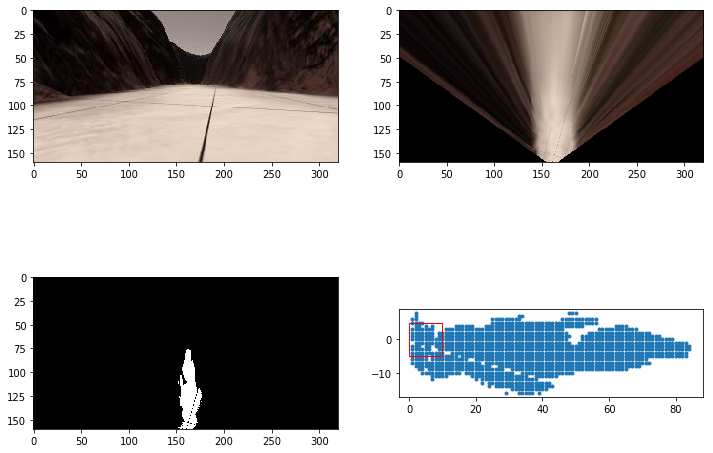

In [7]:
import matplotlib.patches as patches 

# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
#idx = np.random.randint(0, len(img_list)-1)

image = mpimg.imread(img_list[idx])
warped, mask = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)


n_x = xpix[xpix < 10]
n_y = ypix[(ypix < 5) & (ypix > -5)]


fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(221, aspect='equal')
ax2 = fig.add_subplot(222, aspect='equal')
ax3 = fig.add_subplot(223, aspect='equal')
ax4 = fig.add_subplot(224, aspect='equal')
 
ax1.imshow(image)
ax2.imshow(warped)
ax3.imshow(threshed, cmap='gray')
#ax4.set_ylim(-160, 160)
#ax4.set_xlim(0, 160)
ax4.set_zorder(1000)

arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)

rec = patches.Rectangle([0,-5],width=10,height=10, color='r', fill=False, zorder=20)
arr = patches.Arrow(0, 0, x_arrow, y_arrow, color='red', zorder=20, width=2)

ax4.plot(xpix, ypix, '.')
ax4.add_patch(rec)



## Rocky Patch Midway 

The following code is added after a couple of trials. It was observed during the first autonomous runs that the rover will see a patch of rocks in front of him with navigable terrain available on each side.

The first steering appraoch employed was to calculate the average angle for each navigable pixel in view (by employing the polar transformation). But, in this specific scenario, the rover will keep going forward very close to the rock and sometimes it hits it when the amount of navigable pixels in the left is very close to the amount on the right.

The safety box method is an improvement where we say that if whithin the box, the ratio of navigable terrain to the total number of pixels inside the box is low, then we stop and turn.

The size of this box is determined by trial errors. Although, the baseline is 10x5px (0.5 meters sideways and 1 meter forward). Sideways choice represent a corridor where the rover can keep driving without hitting anything, the front distance depends on the braking force applied to stop the rover


46


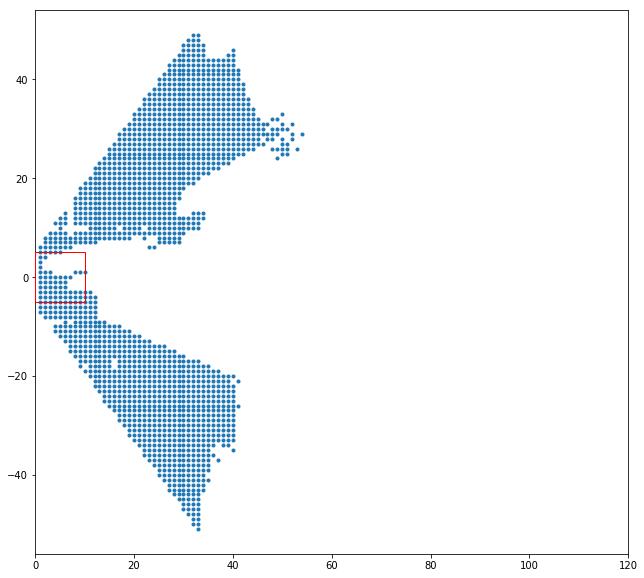

In [8]:
# Grab another random image
#idx = np.random.randint(0, len(img_list)-1)

obstacle = '../calibration_images/obstacle_1.jpg'
image = mpimg.imread(obstacle)
warped, mask = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)


n_x = xpix[(ypix < 5) & (ypix > -5)]
n_x = n_x[(n_x < 10)]
print(len(n_x))


fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111, aspect='equal')
ax1.set_xlim(0,120)

rec = patches.Rectangle([0,-5],width=10,height=10, color='r', fill=False, zorder=20)
ax1.plot(xpix, ypix, '.')
ax1.add_patch(rec)


## Detect the Samples

The following function use a similar approach as color thresholding, but this time to determine the placement of a rock.

Within the simulation code, the position of a rock is used to collect the samples.

The logic (not tested here) is as follows:

1. we average out the rock pixels and convert it to polar coordinates
2. we switch the driving mode of the rover to converge to the rock (steering and throttling commands) 
3. once we are close enought to the rock, we stop and let the manipulator collect the rock.
4. if we don't see the rock anymore, we consider it collected and we revert back to driving mode


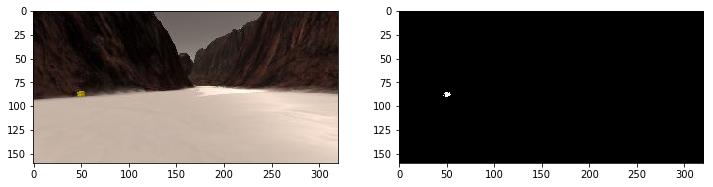

In [9]:
def find_rocks(img, levels=(110,110,50)):
    rock_pix = (img[:,:,0] > levels[0]) \
                & (img[:,:,1] > levels[1]) \
                & (img[:,:,2] < levels[2])
    color_select = np.zeros_like(img[:,:,0])
    color_select[rock_pix] = 1
    
    return color_select

rock = find_rocks(rock_img)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(rock_img)
plt.subplot(122)
plt.imshow(rock, cmap='gray')

## Read in saved data and ground truth map of the world

In the following code, we read the saved data from the training run and collect them into a series of images, telemetry data in order to emulate a driving run


In [10]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

The function below is the most important function. All the processing happens here. It is basically a collection of calls to the developed methods above.

This function is based on the following video https://www.youtube.com/watch?v=oJA6QHDPdQw . There is room for improvement but works pretty fine for our needs

In [11]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    
    # We apply perspective transform to get top-view of the image
    # and the mask to account for camera FOV
    warped, mask = perspect_transform(img, source, destination)
    # Apply color threshold to identify navigable terrain
    col_thres = color_thresh(warped)
    # Identify Obstacle map
    obs_map   = np.absolute(np.float32(col_thres) - 1) * mask 
    
    # To rover coordinates Navigable terrain + Obstacle Map
    xpix, ypix = rover_coords(col_thres)
    xobs, yobs = rover_coords(obs_map)
    
    scale = 2*dst_size 
    world_size = data.worldmap.shape[0]
    
    # Rover Data 
    xpos = data.xpos[data.count]
    ypos = data.ypos[data.count]
    yaw  = data.yaw[data.count]
    
    # To world coordinates 
    x_world, y_world = pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale)
    x_obs_world, y_obs_world = pix_to_world(xobs, yobs, xpos, ypos, yaw, world_size, scale)
      
    # World 
    data.worldmap[y_world, x_world, 2] = 255    
    data.worldmap[y_obs_world, x_obs_world, 0] = 255     
    nav_pix = data.worldmap[:,:,2] > 0
    data.worldmap[nav_pix,0] =0
    
    data.worldmap[int(ypos)-1:int(ypos)+1,int(xpos)-1:int(xpos)+1,:] = 0
    data.worldmap[int(ypos)-1:int(ypos)+1,int(xpos)-1:int(xpos)+1,:] = 0
    data.worldmap[int(ypos)-1:int(ypos)+1,int(xpos)-1:int(xpos)+1,:] = 0
    
    
    # Rocks 
    rock_map = find_rocks(warped, levels=(110,110,50))
    if rock_map.any():
        rock_x, rock_y = rover_coords(rock_map)
        rock_x_world, rock_y_world = pix_to_world(rock_x, rock_y, xpos, ypos, yaw, world_size, scale)
        data.worldmap[rock_y_world, rock_x_world, 0] = 255 
        data.worldmap[rock_y_world, rock_x_world, 1] = 255 
        data.worldmap[rock_y_world, rock_x_world, 2] = 255 
    
    
    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Hello ROBO!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Here we use [moviepy](https://zulko.github.io/moviepy/) library to process images and create a resulting video that simulator a driving run.
  

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=25) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|██████████| 233/233 [00:03<00:00, 69.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

CPU times: user 2.9 s, sys: 132 ms, total: 3.03 s
Wall time: 3.72 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [13]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [14]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))